## E(3)-Equivariant Message-Passing Networks

Here, we briefly introduce E(3)-equivariant message-passing networks.

A message-passing network is a neural network that operates on a graph, computing node and graph-level representations.

The nodes of the graph are associated with feature vectors.
For example, in a molecular graph, each node can represent an atom and the initial feature vector can represent the atom type embedded as a vector.

The message-passing network operates in iterations.
At each iteration of message-passing, each node aggregates messages from its neighbors and updates its own feature vector. 

See these [Distill](https://distill.pub/2021/gnn-intro/) [articles](https://distill.pub/2021/understanding-gnns/) for an interactive introduction to graph neural networks!


Here, we will implement a simpler version of [NequIP](https://www.nature.com/articles/s41467-022-29939-5). The operation of the network is shown in the figure below. If this doesn't make sense to you, don't worry! We will explain the details in the following sections.

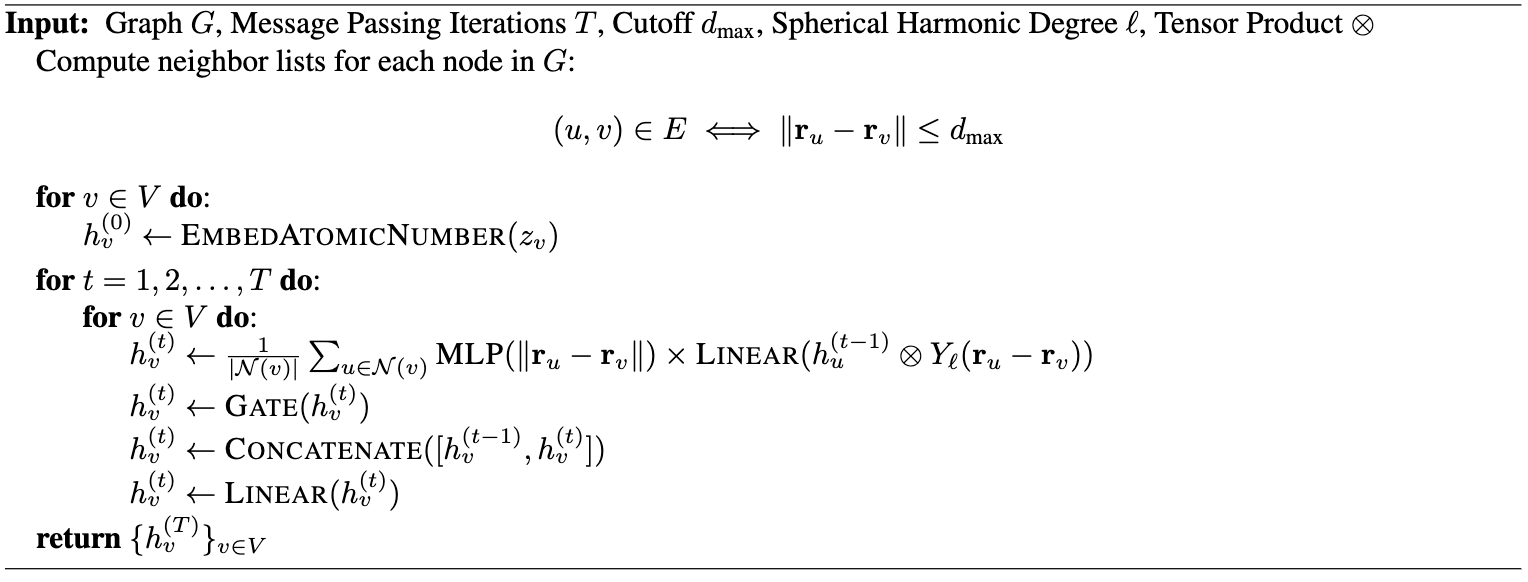

In [ ]:
# Imports
from typing import Callable, Tuple, Sequence
import flax.linen as nn

import jax
import jax.numpy as jnp
import jraph
import e3nn_jax as e3nn

First, let's discuss [Flax](https://github.com/google/flax), the JAX framework that we will use to implement the network.

Flax allows us to define neural networks in JAX, but in a way similar to that of PyTorch.

Let's see how we can define a multi-layer perceptron (MLP) in Flax.

In [ ]:
class MLP(nn.Module):
    """A simple multi-layer perceptron."""

    # These are attributes.
    output_dims: int
    hidden_dims: int
    num_layers: int

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for _ in range(self.num_layers - 1):
            x = nn.Dense(features=self.hidden_dims)(x)
            x = nn.LayerNorm()(x)
            x = nn.silu(x)
        x = nn.Dense(features=self.output_dims)(x)
        return x

*@nn.compact* is a decorator that allows us to define submodules (eg. nn.Dense, nn.LayerNorm above) within the __call__ method.

Another thing that you may notice is the automatic shape inference: we didn't need to define the input dimensions of 'x' above. 

We can create a model as follows:

In [ ]:
model = MLP(output_dims=5, hidden_dims=8, num_layers=2)

JAX is a functional language, which means that we need to explicitly pass in the parameters to the model when calling it. This is different from PyTorch, where the parameters are stored in the model.

Fortunately, Flax provides a convenient way to handle this. We can use the 'init' method to initialize the model and the 'apply' method to call it.

JAX is also explicit about randomness. We need to pass in a PRNGKey to the model when calling it, which is a seed for the random number generator.

In [ ]:
x = jnp.ones((3, 4))
rng = jax.random.PRNGKey(0)

# Initialize the model.
rng, init_rng = jax.random.split(rng)
params = model.init(init_rng, x)

# Flax provides a convenient way to print the model structure, inputs and outputs.
print(nn.tabulate(model, init_rng)(x))

How does one train a model in Flax?


In [ ]:
def compute_features_of_relative_vectors(
    relative_vectors: jnp.ndarray, lmax: int
) -> Tuple[e3nn.IrrepsArray, jnp.ndarray]:
    """Compute the spherical harmonics of the relative vectors and their norms."""
    relative_vectors_sh = e3nn.spherical_harmonics(
        e3nn.s2_irreps(lmax=lmax),
        relative_vectors,
        normalize=True,
        normalization="norm",
    )
    relative_vectors_norm = jnp.linalg.norm(relative_vectors, axis=-1, keepdims=True)
    return relative_vectors_sh, relative_vectors_norm


class AtomEmbedding(nn.Module):
    """Embeds atomic numbers into a learnable vector space."""

    embed_dims: int
    max_atomic_number: int

    @nn.compact
    def __call__(self, atomic_numbers: jnp.ndarray) -> jnp.ndarray:
        atom_embeddings = nn.Embed(
            num_embeddings=self.max_atomic_number, features=self.embed_dims
        )(atomic_numbers)
        return e3nn.IrrepsArray(f"{self.embed_dims}x0e", atom_embeddings)


class SimpleNetworkLayer(nn.Module):
    """A layer of a simple E(3)-equivariant message passing network."""

    mlp_hidden_dims: int
    mlp_num_layers: int
    output_irreps: e3nn.Irreps
    tensor_product_fn: Callable[[], nn.Module]

    @nn.compact
    def __call__(
        self,
        node_features: e3nn.IrrepsArray,
        senders: jnp.ndarray,
        receivers: jnp.ndarray,
        relative_vectors_sh: e3nn.IrrepsArray,
        relative_vectors_norm: jnp.ndarray,
    ) -> e3nn.IrrepsArray:
        # Compute the skip connection.
        node_features_skip = node_features

        # Tensor product of the relative vectors and the neighbouring node features.
        node_features_broadcasted = node_features[senders]
        node_features_broadcasted = self.tensor_product_fn()(
            relative_vectors_sh, node_features_broadcasted
        )

        # Simply multiply each irrep by a learned scalar, based on the norm of the relative vector.
        scalars = mlp.MLP(
            output_dims=node_features_broadcasted.irreps.num_irreps,
            hidden_dims=self.mlp_hidden_dims,
            num_layers=self.mlp_num_layers,
        )(relative_vectors_norm)
        scalars = e3nn.IrrepsArray(f"{scalars.shape[-1]}x0e", scalars)
        node_features_broadcasted = jax.vmap(lambda scale, feature: scale * feature)(
            scalars, node_features_broadcasted
        )

        # Aggregate the node features back.
        node_features = e3nn.scatter_mean(
            node_features_broadcasted,
            dst=receivers,
            output_size=node_features.shape[0],
        )

        # Apply a non-linearity.
        # Note that using an unnormalized non-linearity will make the model not equivariant.
        gate_irreps = e3nn.Irreps(f"{node_features.irreps.num_irreps}x0e")
        node_features_expanded = e3nn.flax.Linear(node_features.irreps + gate_irreps)(
            node_features
        )
        node_features = e3nn.gate(node_features_expanded)

        # Add the skip connection.
        node_features = e3nn.concatenate([node_features, node_features_skip])

        # Apply a linear transformation to the output.
        node_features = e3nn.flax.Linear(self.output_irreps)(node_features)
        return node_features


class SimpleNetwork(nn.Module):
    """A simple E(3)-equivariant message passing network."""

    sh_lmax: int
    init_embed_dims: int
    max_atomic_number: int
    mlp_hidden_dims: int
    mlp_num_layers: int
    output_irreps_per_layer: Sequence[e3nn.Irreps]
    tensor_product_fn: Callable[[], nn.Module]
    readout: nn.Module

    @nn.compact
    def __call__(self, graphs: jraph.GraphsTuple) -> jnp.ndarray:
        # Node features are initially the atomic numbers embedded.
        node_features = graphs.nodes["numbers"]
        node_features = AtomEmbedding(
            embed_dims=self.init_embed_dims,
            max_atomic_number=self.max_atomic_number,
        )(node_features)

        # Precompute the spherical harmonics of the relative vectors.
        positions = graphs.nodes["positions"]
        relative_vectors = positions[graphs.receivers] - positions[graphs.senders]
        (
            relative_vectors_sh,
            relative_vectors_norm,
        ) = compute_features_of_relative_vectors(
            relative_vectors,
            lmax=self.sh_lmax,
        )

        # Message passing.
        for output_irreps in self.output_irreps_per_layer:
            node_features = SimpleNetworkLayer(
                mlp_hidden_dims=self.mlp_hidden_dims,
                mlp_num_layers=self.mlp_num_layers,
                tensor_product_fn=self.tensor_product_fn,
                output_irreps=output_irreps,
            )(
                node_features,
                graphs.senders,
                graphs.receivers,
                relative_vectors_sh,
                relative_vectors_norm,
            )

        # Readout.
        return self.readout(node_features, graphs)